In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

plt.rcParams.update({
    "figure.dpi": 600,
    "figure.figsize": (6, 2.5),
    "font.size": 8,
    "mathtext.fontset": "stix"
})

In [5]:
# Load vmem simulation data
base_dir = '/Users/susannedahle/CellTypeDependenceElStim/simulation_data/vmem_data_neo' 

vmem_amp_file_paths = [
    os.path.join(base_dir, f'vmem_amp_data_neo_Ez_{i}.npy')
    for i in range(16)
]

vmem_amp_data_list = [
    np.load(path, allow_pickle=True).item()
    for path in vmem_amp_file_paths
]
vmem_amp_data = {}
for data in vmem_amp_data_list:
    vmem_amp_data.update(data)

In [6]:
avg_amp_data_celltype = []

def calculate_avg_soma_amplitude(amp_data):
    """ Categorizes cells based on their names and calculates the average and standard deviation of soma amplitudes for each frequency within each category. """
    global avg_amp_data_celltype

    avg_amp_data_celltype = []

    # Dictionary to store categorized data
    categorized_data = {}

    # Loop through each cell and organize data by category
    for cell_name, data in amp_data.items():
        # Determine the category of the cell
        if 'PC' in cell_name or 'SP' in cell_name:
            cell_category = 'Pyramidal cells'
        elif 'SS' in cell_name:
            cell_category = 'Spiny Stellate cells'
        else: cell_category = 'Inhibitory neurons'
            
        
        # Initialize category in dictionary if not present
        if cell_category not in categorized_data:
            categorized_data[cell_category] = {}
        
        # Organize soma amplitudes by frequency
        for freq, soma_amp in zip(data['freq'], data['soma_amp']):
            if freq not in categorized_data[cell_category]:
                categorized_data[cell_category][freq] = []
            categorized_data[cell_category][freq].append(soma_amp)
    
    # Compute averages and standard deviations
    for category, freq_data in categorized_data.items():
        category_result = {
            'cell_category': category,
            'frequencies': [],
            'soma_amplitude': [],
            'std': []
        }
        
        for freq, amplitudes in sorted(freq_data.items()):
            category_result['frequencies'].append(freq)
            category_result['soma_amplitude'].append(np.mean(amplitudes))
            category_result['std'].append(np.std(amplitudes))
        

        avg_amp_data_celltype.append(category_result)
    

In [7]:
def plot_soma_combined(amp_data, selected_cells, avg_amp_data_celltype):
    """
    Creates a figure with two subplots:
    (A) Soma Vm amplitudes for all neurons with selected cells highlighted
    (B) Neuron-type averages with standard deviation
    """

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
    fig.subplots_adjust(bottom=0.22, left=0.08, right=0.97, top=0.88, wspace=0.4)

    # ------------------- Subplot A -------------------
    for cell_name, data in amp_data.items():
        if cell_name in selected_cells:
            continue
        freqs = data['freq']
        amps = data['soma_amp']

        if 'PC' in cell_name or 'SP' in cell_name:
            color, alpha, lw, label = 'tab:green', 0.6, 0.5, 'Pyramidal cells'
        elif 'SS' in cell_name:
            color, alpha, lw, label = 'tab:purple', 1, 0.6, 'Spiny Stellate cells'
        else:
            color, alpha, lw, label = 'tab:orange', 0.15, 0.5, 'Inhibitory neurons'

        ax1.loglog(freqs, amps, color=color, alpha=alpha, lw=lw)

    for cell_name in selected_cells:
        if cell_name not in amp_data:
            continue
        freqs = amp_data[cell_name]['freq']
        amps = amp_data[cell_name]['soma_amp']
        ax1.loglog(freqs, amps, color='black', lw=0.6, alpha=1)

    ax1.set_xlabel('Frequency [Hz]', fontsize=8)
    ax1.set_ylabel('Soma $V_\mathrm{m}$ Amplitude [mV]', fontsize=8)
    ax1.set_title('All neocortical neuron models', fontsize=10)
    ax1.grid(which='major', linestyle='-', linewidth=0.5, alpha=0.8)
    ax1.grid(which='minor', linestyle=':', linewidth=0.3, alpha=0.6)
    ax1.set_xlim(left=freqs[0], right=freqs[-1])

    # Custom legend
    custom_legend = [
        Line2D([0], [0], color='black', lw=0.6, label='Example cells'),
        Line2D([0], [0], color='tab:green', lw=0.6, label='Pyramidal cells'),
        Line2D([0], [0], color='tab:purple', lw=0.6, label='Spiny Stellate cells'),
        Line2D([0], [0], color='tab:orange', lw=0.6, label='Inhibitory neurons'),
    ]
    ax1.legend(handles=custom_legend, loc='lower left', fontsize=7, ncol=1)

    # ------------------- Subplot B -------------------
    for cell_data in avg_amp_data_celltype:
        freqs = np.array(cell_data['frequencies'])
        avg = np.array(cell_data['soma_amplitude'])
        std = np.array(cell_data['std'])
        upper, lower = avg + std, avg - std

        if cell_data['cell_category'] == 'Pyramidal cells':
            color = 'tab:green'
        elif cell_data['cell_category'] == 'Spiny Stellate cells':
            color = 'tab:purple'
        else:
            color = 'tab:orange'

        ax2.loglog(freqs, avg, linestyle='--', lw=1, label=f"{cell_data['cell_category']} avg",
                   color=color, marker='.', markersize=4)
        ax2.fill_between(freqs, lower, upper, color=color, alpha=0.2)

    ax2.set_xlabel('Frequency [Hz]', fontsize=8)
    ax2.set_ylabel('Soma $V_\mathrm{m}$ Amplitude [mV]', fontsize=8)
    ax2.set_title('Neuron-type averages', fontsize=10)
    ax2.grid(which='major', linestyle='-', linewidth=0.5, alpha=0.8)
    ax2.grid(which='minor', linestyle=':', linewidth=0.3, alpha=0.6)
    ax2.set_xlim(left=freqs[0], right=freqs[-1])
    ax2.legend(fontsize=7, loc='lower left')

    # ------------------- Add subplot labels -------------------
    ax1.text(-0.15, 1.05, 'A', transform=ax1.transAxes, fontsize=12, fontweight='bold')
    ax2.text(-0.15, 1.05, 'B', transform=ax2.transAxes, fontsize=12, fontweight='bold')

    plt.show()


<>:35: SyntaxWarning: invalid escape sequence '\m'
<>:69: SyntaxWarning: invalid escape sequence '\m'
<>:35: SyntaxWarning: invalid escape sequence '\m'
<>:69: SyntaxWarning: invalid escape sequence '\m'
/var/folders/bg/0phzw_wj05x5crg_p858d9b80000gn/T/ipykernel_44956/4040465312.py:35: SyntaxWarning: invalid escape sequence '\m'
  ax1.set_ylabel('Soma $V_\mathrm{m}$ Amplitude [mV]', fontsize=8)
/var/folders/bg/0phzw_wj05x5crg_p858d9b80000gn/T/ipykernel_44956/4040465312.py:69: SyntaxWarning: invalid escape sequence '\m'
  ax2.set_ylabel('Soma $V_\mathrm{m}$ Amplitude [mV]', fontsize=8)


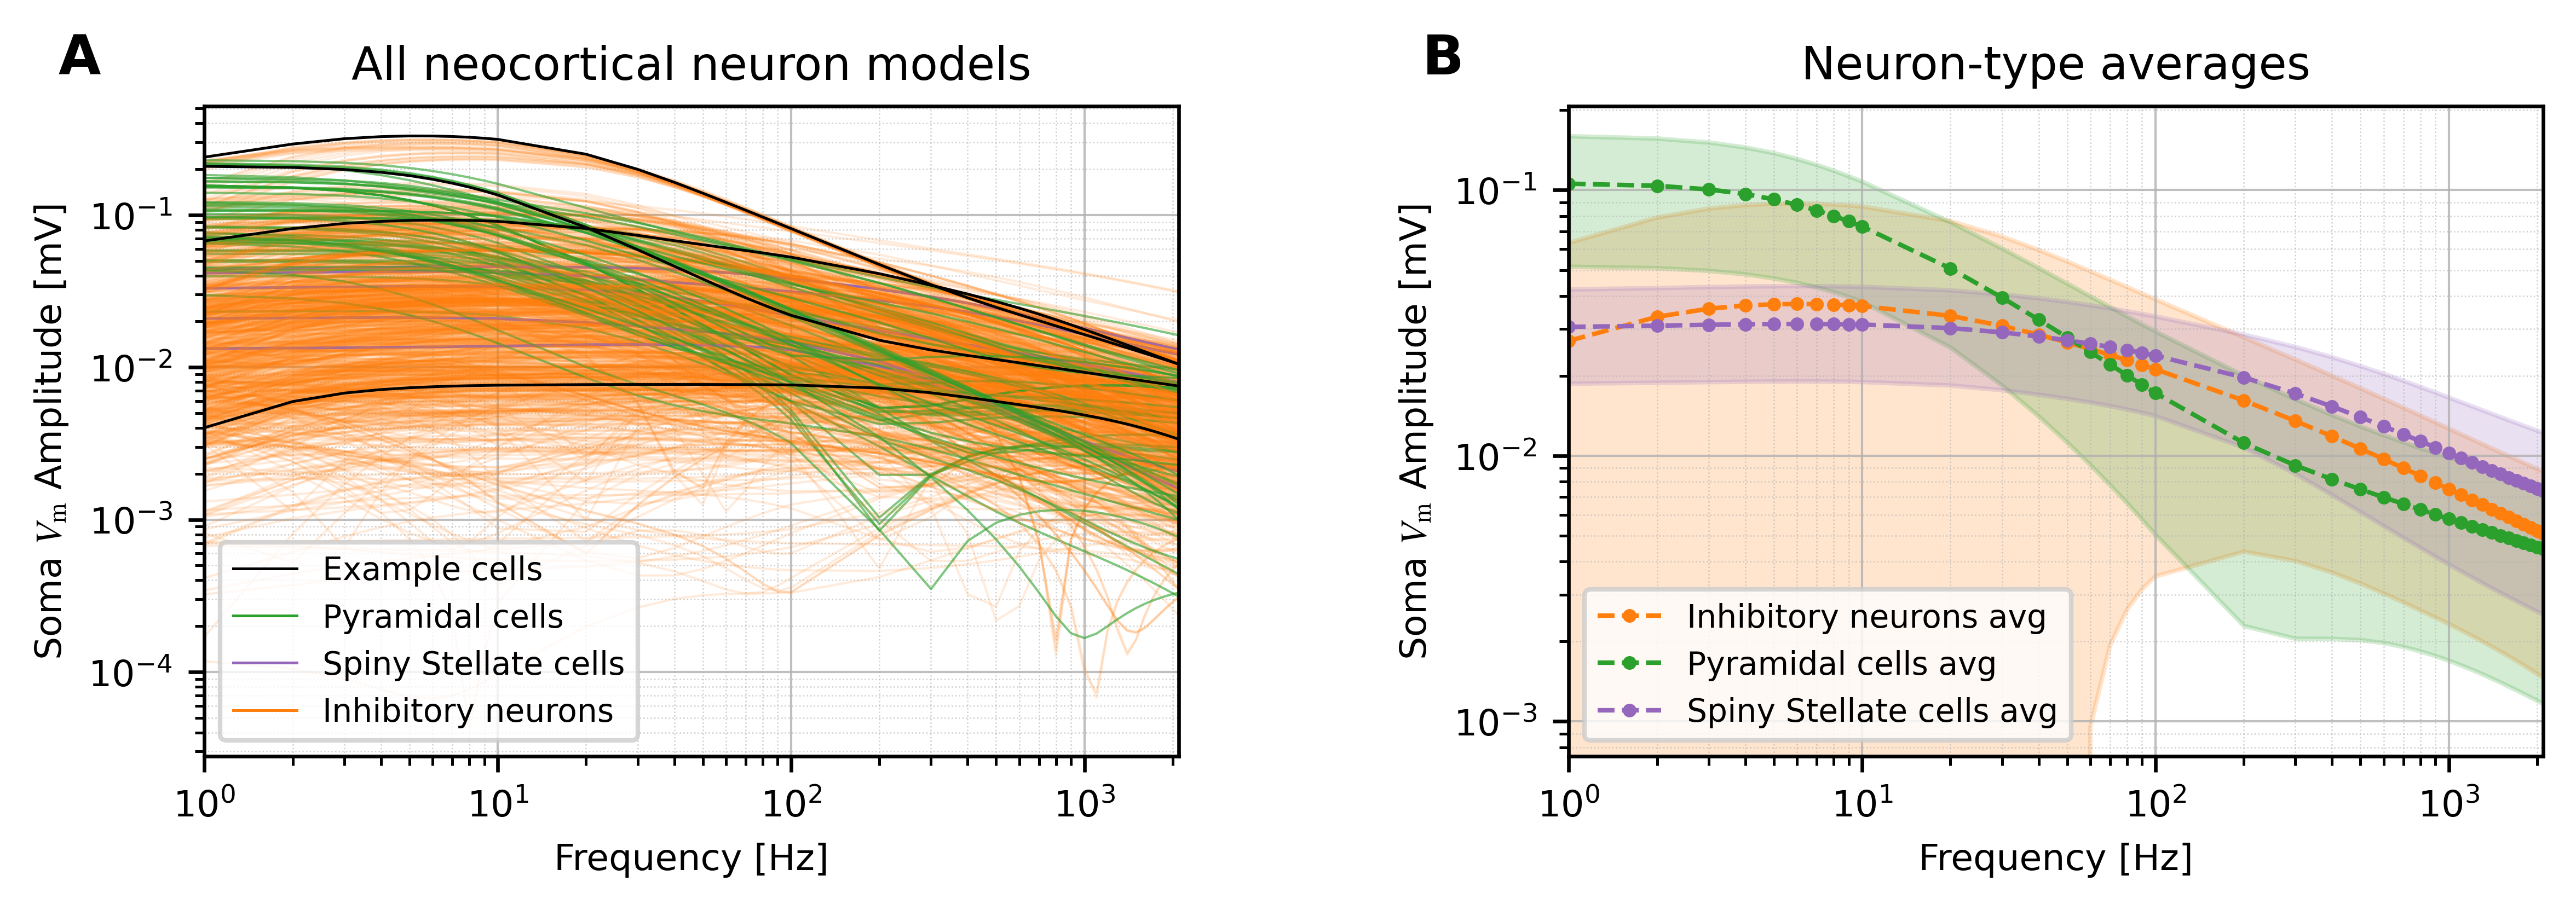

In [8]:
selected_cells = ['L4_BP_bIR215_5', "L5_MC_bAC217_1", "L5_TTPC2_cADpyr232_3", "L5_NGC_bNAC219_5"]
calculate_avg_soma_amplitude(vmem_amp_data)
plot_soma_combined(vmem_amp_data, selected_cells, avg_amp_data_celltype)